 


# Traffic Signs Classifier, Deep Neural Network Implemented with TensorFlow



---

## 1. Dataset Exploration: 
[German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). 


The pickled files include dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)
 
### Load Libraries and Data

In [1]:
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 7)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load pickled data and creating the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

### Summary Statistics

In [3]:
#  Number of training examples
n_train = len (X_train)

#  Number of testing examples
n_test = len (X_test)

#  Shape of an image 
image_shape = X_train.shape[1:]

# Number of classes in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Data visualization: 
I would like to examine the different traffic signs in the dataset and the count distribution for each traffic sign. 


#### The available traffic signs.

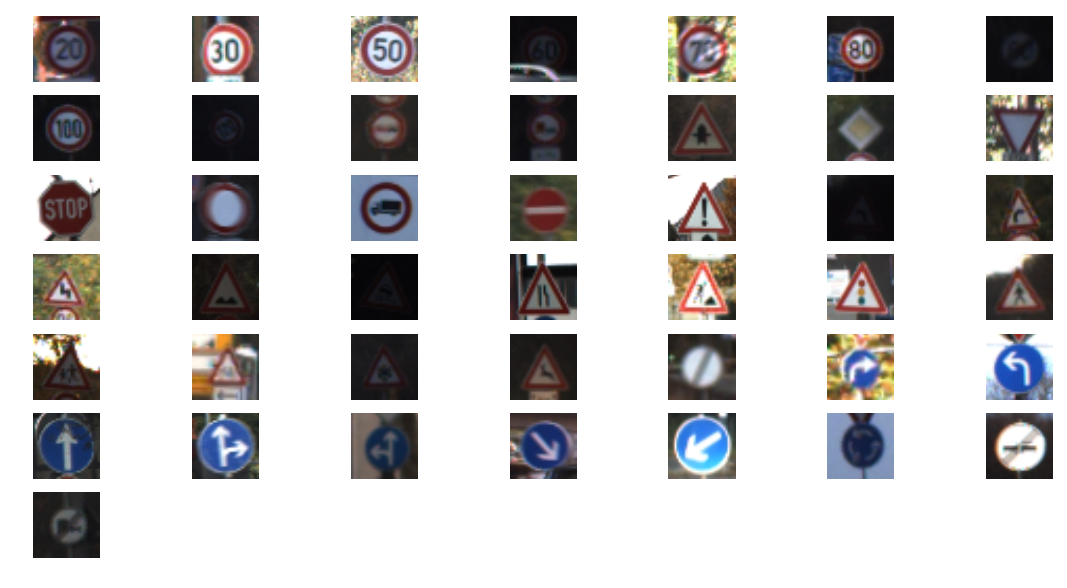

In [4]:
label_type=[]
for i  in  range(0,n_classes):
    plt.subplot(7,7,i+1)
    label_type.append(X_test[np.where( y_test == i )[0][0],:,:,:].squeeze())
    img = plt.imshow(X_test[np.where( y_test == i )[0][0],:,:,:].squeeze())
    plt.axis('off')

Figure 1: The different traffic sighns labels included in the data

#### Traffic signs count distribution.

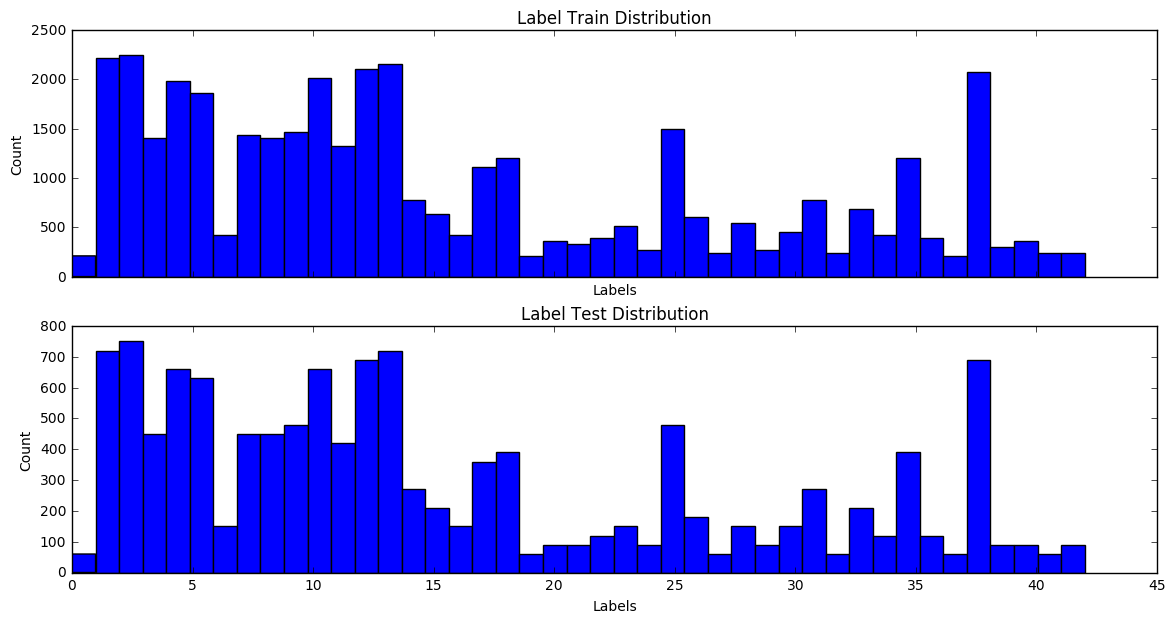

In [5]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].hist(y_train,bins=n_classes)
axarr[0].set_title('Label Train Distribution')
axarr[0].set_xlabel('Labels')
axarr[0].set_ylabel('Count')
axarr[1].hist(y_test,bins=n_classes)
axarr[1].set_title('Label Test Distribution')
axarr[1].set_xlabel('Labels')
axarr[1].set_ylabel('Count')


Figure 2: the count distribution for each traffic signlabel. 

---
## 2. Preprocessing 

### Gray scale,
Since traffic signs are designed also for color blind people, the color information is redundant. That allows us to simplify and decrease the problem dimension by using grayscale images. I decideed to conver the color into the  [HSL model(Hue, Saturation, Lightness)](https://en.wikipedia.org/wiki/HSL_and_HSV) That attempts to resemble perceptual color models placing fully saturated colors around a circle at a lightness value of 1/2, where a lightness value of 0 or 1 is fully black or white, respectively.

In [6]:
X_test_t = cv2.cvtColor(X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2],X_test.shape[3]), cv2.COLOR_RGB2HLS)
X_train_t = cv2.cvtColor(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2],X_train.shape[3]), cv2.COLOR_RGB2HLS)

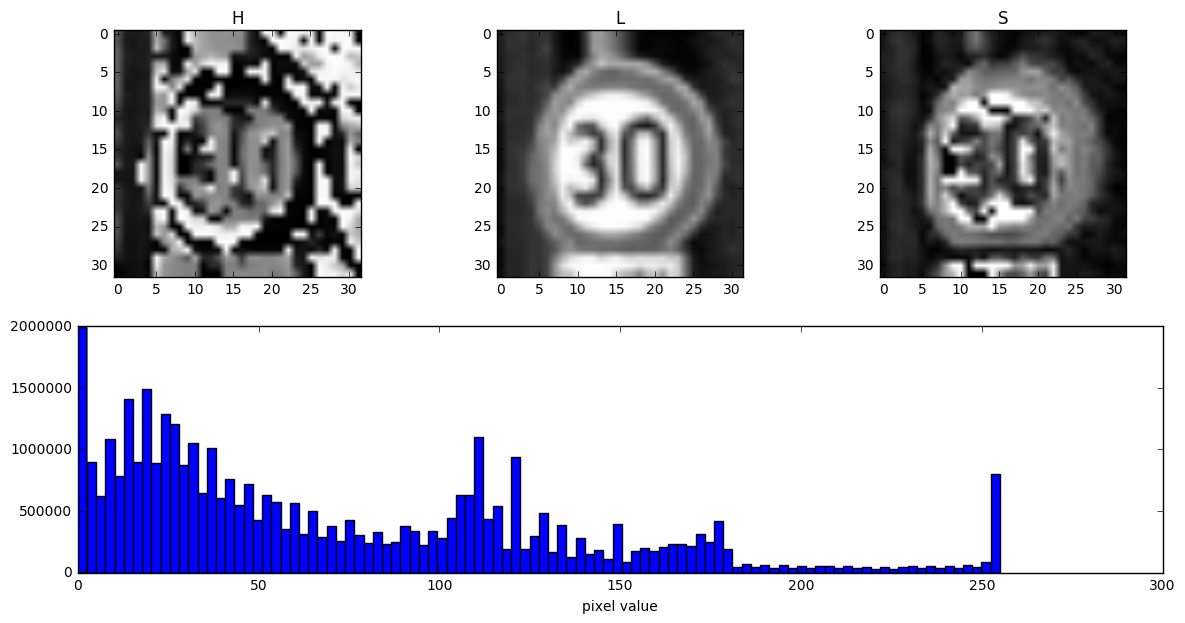

In [6]:
plt.subplot(2,3,1)
plt.imshow(X_test_t.reshape(X_test_t.shape[0], 32,32,3)[1,:,:,0].squeeze(), cmap='gray')
title('H')
plt.subplot(2,3,2)
plt.imshow(X_test_t.reshape(X_test_t.shape[0], 32,32,3)[1,:,:,1].squeeze(), cmap='gray')
title('L')
plt.subplot(2,3,3)
plt.imshow(X_test_t.reshape(X_test_t.shape[0], 32,32,3)[1,:,:,2].squeeze(), cmap='gray')
title('S')
plt.subplot(2,1,2)
plt.hist(X_test_t.reshape(X_test_t.shape[0]*32*32*3),bins=100 )
plt.xlabel('pixel value')
plt.show()

Figure 3: The different HSL channels. We can clearly see that the images that represents the "L" channel include important information. That was also confirmed with the model (not included in this report).  When the model get the  "L" channel as input performance was higher. 

#### Performance of the model on each dimension

dim = H Test Accuracy: 0.49

dim = L Test Accuracy: 0.90

dim = S Test Accuracy: 0.58

### Normalize the figures
For this project we obtained colorful images with different illumination condition. If we didn't scale our input training vectors, the ranges of our distributions of feature values would likely be different for each feature, and thus the learning rate would cause corrections in each dimension that would differ from one another. 

 * In order to reduce the **total variance** in the dataset and simplify the training I normalized each figure with respect to the values0-255 -> 0.1 -0.9. The normalization was performed on each color separately. That was done in order to enhance **variation between** different colors. 
 * For the target variable I simply transform the type of the different traffic signs using One-Hot Encoding. 
 
[why we normalize 1](http://stats.stackexchange.com/questions/185853/why-do-we-need-to-normalize-the-images-before-we-put-them-into-cnn) 

[why we normalize 2](http://cs231n.github.io/neural-networks-2/)


In [7]:
X_test_n = (X_test_t*(0.8)/255)-0.4
X_train_n = (X_train_t*(0.8)/255 )-0.4

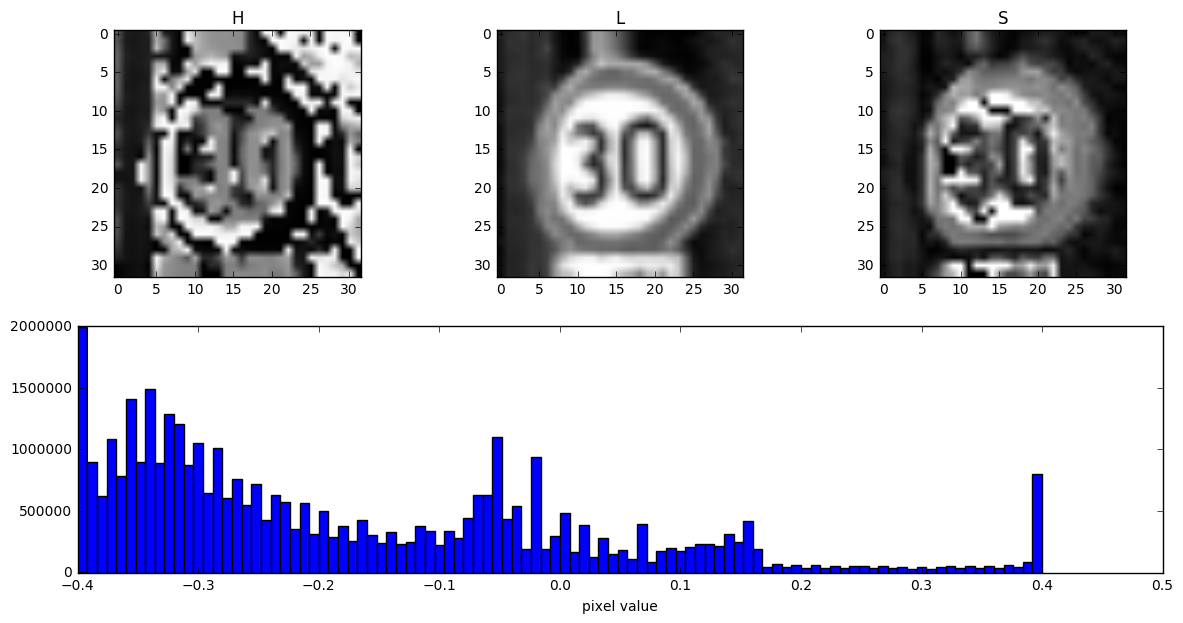

In [21]:
plt.subplot(2,3,1)
plt.imshow(X_test_n.reshape(X_test_n.shape[0], 32,32,3)[1,:,:,0].squeeze(), cmap='gray')
title('H')
plt.subplot(2,3,2)
plt.imshow(X_test_n.reshape(X_test_n.shape[0], 32,32,3)[1,:,:,1].squeeze(), cmap='gray')
title('L')
plt.subplot(2,3,3)
plt.imshow(X_test_n.reshape(X_test_n.shape[0], 32,32,3)[1,:,:,2].squeeze(), cmap='gray')
title('S')
plt.subplot(2,1,2)
plt.hist(X_test_n.reshape(X_test_n.shape[0]*32*32*3),bins=100 )
plt.xlabel('pixel value')
plt.show()

Figure 4: The different channels after the normalizations. We can clearly see that the information that each figure represent is preserved but the distribution is much narrower.  

### Transform labels using One-Hot Encoding

In [8]:
from sklearn.preprocessing import LabelBinarizer

# Turn labels into numbers and apply One-Hot Encoding
encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)
is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


### Other Preprocessing 
We can also use augmentation to create fake data by adding noise to the figures orientations the figures and similar manipulation, That can be used to create equal distribution so each traffic sign will get similar training. 

### Splitting and randomize datasets for training and validation sets

The provided dataset is already separated into training and testing. I used the function "train_test_split", to shuffle and split the training set into training (70%) and validation (30%). That will allow us to train and tune the model on a seperate data set and then the final model performance will be estimated using a complete seperate dataset. 

In [9]:
from sklearn.model_selection import train_test_split

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    X_train_n,
    y_train,
    test_size=0.3,
    random_state=0)


### Choosing the preferd dimension "L"

In [10]:
dim=1
valid_features_1=valid_features.reshape(valid_features.shape[0], 32,32,3)[:,:,:,dim,np.newaxis]
train_features_1=train_features.reshape(train_features.shape[0], 32,32,3)[:,:,:,dim,np.newaxis]
X_test_n_1=X_test_n.reshape(X_test_n.shape[0], 32,32,3)[:,:,:,dim,np.newaxis]
 

----

## 3. Design and Test the Model Architecture

There are various aspects to consider when thinking about this problem:

- The model can be derived from a deep feedforward net or a deep convolutional network.
- Number of examples per label (some have more than others).
- Generate fake data.

 

### Network architecture 
 

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** For this problem I am using the ** multi-layer perceptron feedforward model**. The neural network include **2 layers**, the size of the hidden layer, or the **width of a layer is 512**. Each layer include also **RELU** activation layer in order to include non linear components in the network. The input size is 3072, the output size is 43.

The **cost** function is calculated using the **[softmax_cross_entropy_with_logits](http://stackoverflow.com/questions/34240703/difference-between-tensorflow-tf-nn-softmax-and-tf-nn-softmax-cross-entropy-with)**. 

**Accuraccy** is also being calculated. 

I also consider to use convolution network here because it seems more appropriate for this type of problem, the reason is that the sign might change the relative location of the image. However, I still struggling with how to implement that and I would like to get a feedback on this report before continue further. 

### Deep Neural Network in TensorFlow 

In [29]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
#### # Parameters
n_input = train_features.shape[1]
n_classes = train_labels.shape[1]
from tensorflow.contrib.layers import flatten
 
# Parameters
batch_size = 128
epochs = 11
learn_rate = 0.001


# tf Graph input
mu = 0
sigma = 0.1

def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    outout_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        outout_batches.append(batch)
        
    return outout_batches

def print_epoch_stats(epoch_i, sess, last_features, last_labels):
    """
    Print cost and validation accuracy of an epoch
    """
    current_cost = sess.run(
        cost,
        feed_dict={x: last_features, y: last_labels})
    valid_accuracy = sess.run(
        accuracy,
        feed_dict={x: valid_features_1, y: valid_labels})
    
    print('Epoch: {:<4} - Cost: {:<8.3} Valid Accuracy: {:<5.3}'.format(
        epoch_i,
        current_cost,
        valid_accuracy))    
    val_acc_batch.append([valid_accuracy])
  
 
x = tf.placeholder(tf.float32, (None, 32, 32,1 ))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

    #  Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
conv1W = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 6], mean=mu, stddev=sigma))
conv1b = tf.Variable(tf.zeros(6))
conv1Wb = tf.nn.conv2d(x, conv1W, strides=[1,1,1,1], padding='VALID') + conv1b

# Activation.    
conv1 = tf.nn.relu(conv1Wb)
 
    # Layer 2: Convolutional. Output = 10x10x16.
conv2W = tf.Variable(tf.truncated_normal(shape=[5, 5, 6, 16], mean=mu, stddev=sigma))
conv2b = tf.Variable(tf.zeros(16))
conv2Wb = tf.nn.conv2d(conv1, conv2W, strides=[1,1,1,1], padding='VALID') + conv2b
    
    #  Activation.
conv2 = tf.nn.relu(conv2Wb)
 
    # Flatten. Input = 5x5x16. Output = 400.
conv2PF = flatten(conv2)
    
    #  Layer 3: Fully Connected. Input = 400. Output = 120.
fc1W = tf.Variable(tf.truncated_normal(shape=[9216 , 120], mean=mu, stddev=sigma))
fc1b = tf.Variable(tf.zeros(120))
fc1Wb = tf.matmul(conv2PF, fc1W) + fc1b
    
    #  Activation.
fc1 = tf.nn.relu(fc1Wb)

    #  Layer 4: Fully Connected. Input = 120. Output = 84.
fc2W = tf.Variable(tf.truncated_normal(shape=[120, 84], mean=mu, stddev=sigma))
fc2b = tf.Variable(tf.zeros(84))
fc2Wb = tf.matmul(fc1, fc2W) + fc2b
    
    #  Activation.
fc2 = tf.nn.relu(fc2Wb)

    #  Layer 5: Fully Connected. Input = 84. Output = 43.
fc3W = tf.Variable(tf.truncated_normal(shape=[84, 43], mean=mu, stddev=sigma))
fc3b = tf.Variable(tf.zeros(43))
fc3Wb = tf.matmul(fc2, fc3W) + fc3b
    
logits = fc3Wb

prediction = tf.nn.softmax(logits)
#predict = tf.argmax(logits, 1) 
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))

optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(cost)

is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32)) 

init = tf.global_variables_initializer()

 
train_batches = batches(batch_size, train_features_1, train_labels)
train_acc_batch =[]
val_acc_batch =[]
 
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch_i in range(epochs):

        # Loop over all batches
        for batch_features, batch_labels in train_batches:
            train_feed_dict = {
                x: batch_features, 
                y: batch_labels }
            sess.run(optimizer, feed_dict=train_feed_dict)

        # Print cost and validation accuracy of an epoch
        print_epoch_stats(epoch_i, sess, batch_features, batch_labels)
        train_accuracy = sess.run(
        accuracy,
        feed_dict=train_feed_dict)
        
        train_acc_batch.append([train_accuracy])

    # Calculate accuracy for test dataset
    test_accuracy = sess.run(
        accuracy,
        feed_dict={x: X_test_n_1, y: y_test})

print('Test Accuracy: {}'.format(test_accuracy))

Epoch: 0    - Cost: 0.207    Valid Accuracy: 0.883
Epoch: 1    - Cost: 0.0537   Valid Accuracy: 0.945
Epoch: 2    - Cost: 0.0188   Valid Accuracy: 0.954
Epoch: 3    - Cost: 0.0139   Valid Accuracy: 0.955
Epoch: 4    - Cost: 0.0117   Valid Accuracy: 0.967
Epoch: 5    - Cost: 0.00379  Valid Accuracy: 0.967
Epoch: 6    - Cost: 0.00374  Valid Accuracy: 0.973
Epoch: 7    - Cost: 0.0014   Valid Accuracy: 0.975
Epoch: 8    - Cost: 0.00392  Valid Accuracy: 0.973
Epoch: 9    - Cost: 0.000767 Valid Accuracy: 0.972
Epoch: 10   - Cost: 0.00444  Valid Accuracy: 0.972
Test Accuracy: 0.9062554240226746


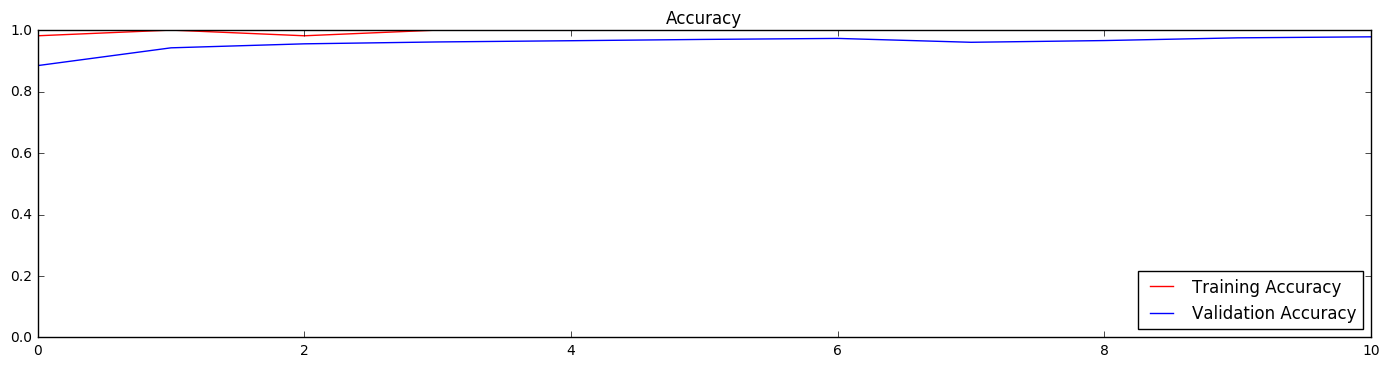

In [26]:
batches=    list=[x for x in range(0,len(train_acc_batch ))]
 
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, val_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

### Tuning the model

It seems that the model convearge very fast and overfit the data. I would like to add some dropout and simplify the model. 

In [109]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

magnitude_spectrum = np.zeros(X_test_t.reshape(X_test_t.shape[0], 32,32,3)[1,:,:,0].squeeze().shape) 
mean_img = np.zeros(X_test_t.reshape(X_test_t.shape[0], 32,32,3)[1,:,:,0].squeeze().shape) 

for i in range(X_test_t.shape[0]):
    img = X_test_t.reshape(X_test_t.shape[0], 32,32,3)[i,:,:,1].squeeze()
    #f = np.fft.fft2(img-mean(img))
    fshift = np.fft.fftshift(np.fft.fft2(img-mean(img)))
    magnitude_spectrum += 20*np.log(np.abs(fshift))
    mean_img+=(img-mean(img))

 

C:\Users\Shmuel Naaman\Anaconda3\envs\keras_1\lib\site-packages\ipykernel\__main__.py:12: RuntimeWarning: divide by zero encountered in log


C:\Users\Shmuel Naaman\Anaconda3\envs\keras_1\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


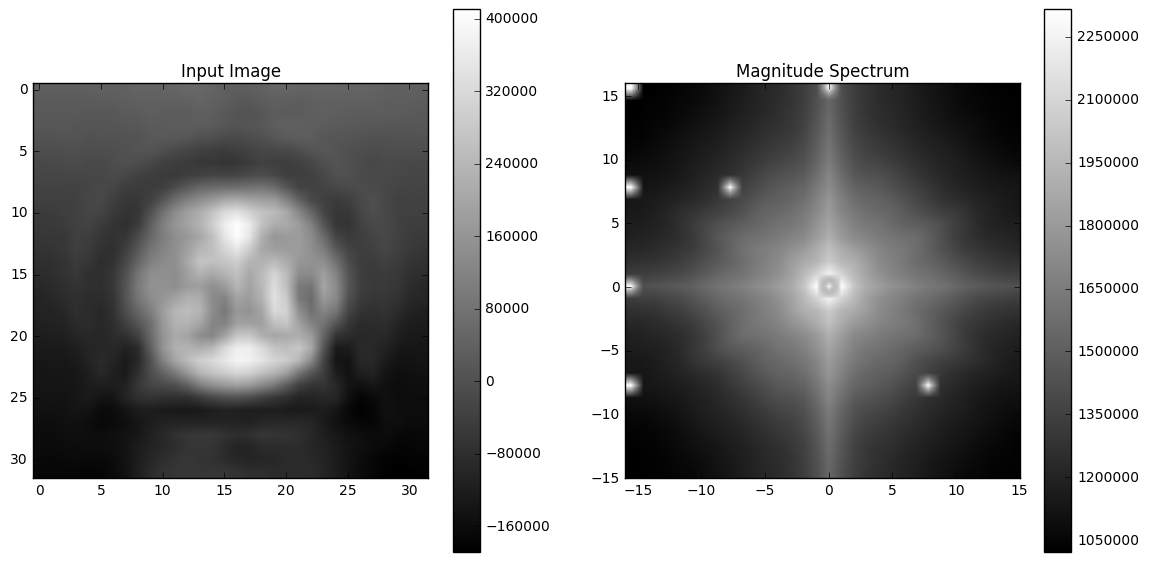

In [116]:
N=32
middle=N/2
ticks=np.arange(-middle,middle+2,2)
extent=(-middle,middle-1,-middle+1,middle )
plt.subplot(121),
plt.imshow(mean_img, cmap = 'gray')
plt.colorbar()
plt.title('Input Image'), 
plt.subplot(122),
plt.imshow(magnitude_spectrum, cmap = 'gray', extent=extent)
plt.colorbar()
plt.title('Magnitude Spectrum') 
plt.legend()
plt.show()

Figure 5: The figure here above depict the average power spectrum obtained from each image on the right. On the left it is just the average image. We can identify high-frequency amplitude at around 8 pixels is the frequency that describe the limits of the traffic signs. and intresting feature will be with a scalelower than this. 

In [11]:
def print_epoch_stats(epoch_i, sess, last_features, last_labels):
    """
    Print cost and validation accuracy of an epoch
    """
    current_cost = sess.run(
        cost,
        feed_dict={x: last_features, y: last_labels})
    valid_accuracy = sess.run(
        accuracy,
        feed_dict={x: valid_features_1, y: valid_labels})
    
    print('Epoch: {:<4} - Cost: {:<8.3} Valid Accuracy: {:<5.3}'.format(
        epoch_i,
        current_cost,
        valid_accuracy))    
    val_acc_batch.append([valid_accuracy])

In [41]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np 
from tensorflow.contrib.layers import flatten


def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    outout_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        outout_batches.append(batch)
        
    return outout_batches
  
####  Parameters
n_input = train_features.shape[1]
n_classes = train_labels.shape[1]
 
batch_size = 128
epochs = 20
learn_rate = 0.001

keep_prob=0.6

# tf Graph input
mu = 0
sigma = 0.1

 
x = tf.placeholder(tf.float32, (None, 32, 32,1 ))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

#  Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6. 
conv1W = tf.Variable(tf.truncated_normal(shape=[4,4, 1, 6], mean=mu, stddev=sigma))
conv1b = tf.Variable(tf.zeros(6))
conv1Wb = tf.nn.conv2d(x, conv1W, strides=[1,1,1,1], padding='VALID') + conv1b

     # Activation.    
conv1 = tf.nn.relu(conv1Wb)
drop_1 = tf.nn.dropout(conv1, keep_prob, noise_shape=None, seed=None, name=None)

  
# Layer 2: Convolutional. Output = 10x10x16.
conv2W = tf.Variable(tf.truncated_normal(shape=[7,7, 6, 16], mean=mu, stddev=sigma))
conv2b = tf.Variable(tf.zeros(16))
conv2Wb = tf.nn.conv2d(drop_1, conv2W, strides=[1,2,2,1], padding='VALID') + conv2b
    
#  Activation.
conv2 = tf.nn.relu(conv2Wb)
drop_2 = tf.nn.dropout(conv2, keep_prob, noise_shape=None, seed=None, name=None)

# Flatten. Input = 5x5x16. Output = 400.
conv2PF = flatten(drop_2)
    
#  Layer 3: Fully Connected. Input = 400. Output = 120.
fc1W = tf.Variable(tf.truncated_normal(shape=[2304, 120], mean=mu, stddev=sigma))
fc1b = tf.Variable(tf.zeros(120))
fc1Wb = tf.matmul(conv2PF, fc1W) + fc1b
    
#  Activation.
fc1 = tf.nn.relu(fc1Wb)

#  Layer 4: Fully Connected. Input = 120. Output = 84.
fc2W = tf.Variable(tf.truncated_normal(shape=[120, 84], mean=mu, stddev=sigma))
fc2b = tf.Variable(tf.zeros(84))
fc2Wb = tf.matmul(fc1, fc2W) + fc2b
    
#  Activation.
fc2 = tf.nn.relu(fc2Wb)

#  Layer 5: Fully Connected. Input = 84. Output = 43.
fc3W = tf.Variable(tf.truncated_normal(shape=[84, 43], mean=mu, stddev=sigma))
fc3b = tf.Variable(tf.zeros(n_classes))
fc3Wb = tf.matmul(fc2, fc3W) + fc3b
    
logits = fc3Wb

prediction = tf.nn.softmax(logits)
predict = tf.argmax(logits, 1) 


# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))

optimizer = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(cost)

is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32)) 

init = tf.global_variables_initializer()

 
train_batches = batches(batch_size, train_features_1, train_labels)
train_acc_batch =[]
val_acc_batch =[]
 
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch_i in range(epochs):

        # Loop over all batches
        for batch_features, batch_labels in train_batches:
            train_feed_dict = {
                x: batch_features, 
                y: batch_labels }
            sess.run(optimizer, feed_dict=train_feed_dict)

        # Print cost and validation accuracy of an epoch
        print_epoch_stats(epoch_i, sess, batch_features, batch_labels)
        train_accuracy = sess.run(
        accuracy,
        feed_dict=train_feed_dict)
        
        train_acc_batch.append([train_accuracy])

    # Calculate accuracy for test dataset
    test_accuracy = sess.run(
        accuracy,
        feed_dict={x: X_test_n_1, y: y_test})

print('Test Accuracy: {}'.format(test_accuracy))

Epoch: 0    - Cost: 0.704    Valid Accuracy: 0.714
Epoch: 1    - Cost: 0.272    Valid Accuracy: 0.837
Epoch: 2    - Cost: 0.184    Valid Accuracy: 0.869
Epoch: 3    - Cost: 0.214    Valid Accuracy: 0.894
Epoch: 4    - Cost: 0.112    Valid Accuracy: 0.917
Epoch: 5    - Cost: 0.136    Valid Accuracy: 0.921
Epoch: 6    - Cost: 0.0748   Valid Accuracy: 0.927
Epoch: 7    - Cost: 0.0352   Valid Accuracy: 0.934
Epoch: 8    - Cost: 0.103    Valid Accuracy: 0.943
Epoch: 9    - Cost: 0.188    Valid Accuracy: 0.947
Epoch: 10   - Cost: 0.0368   Valid Accuracy: 0.951
Epoch: 11   - Cost: 0.0298   Valid Accuracy: 0.953
Epoch: 12   - Cost: 0.0341   Valid Accuracy: 0.954
Epoch: 13   - Cost: 0.0159   Valid Accuracy: 0.958
Epoch: 14   - Cost: 0.0433   Valid Accuracy: 0.958
Epoch: 15   - Cost: 0.0322   Valid Accuracy: 0.959
Epoch: 16   - Cost: 0.0173   Valid Accuracy: 0.951
Epoch: 17   - Cost: 0.0154   Valid Accuracy: 0.958
Epoch: 18   - Cost: 0.00403  Valid Accuracy: 0.96 
Epoch: 19   - Cost: 0.0291   Va

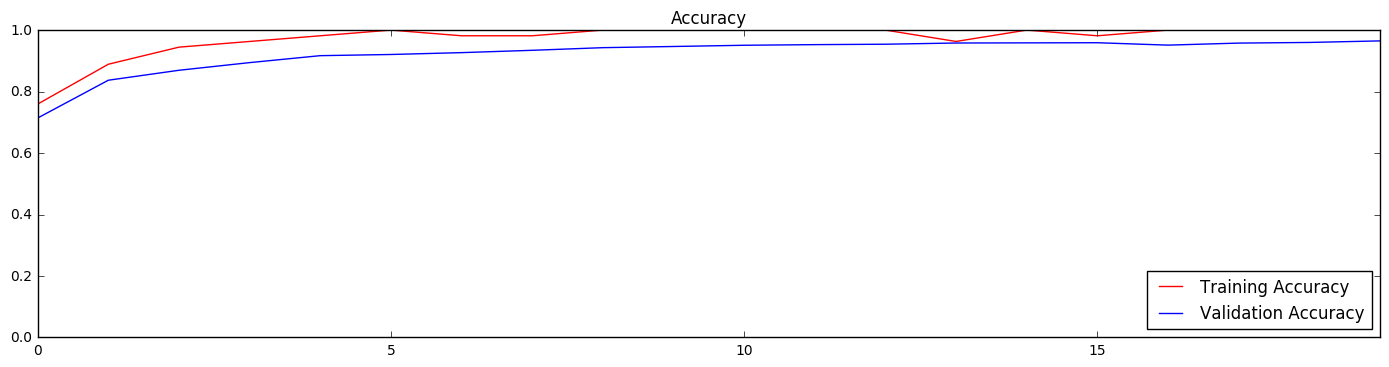

In [42]:
batches=    list=[x for x in range(0,len(train_acc_batch ))]
 
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, val_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

### Visualization for the cost and accuracy (y-axis) with respect to the "training epochs** ( x-axis).

The model was trained with learning rate =0.001, training_epochs = 20, batch_size = 1000. 

The **optimization** is done using the ** [AdamOptimizer](http://stats.stackexchange.com/questions/184448/difference-between-gradientdescentoptimizer-and-adamoptimizer-tensorflow)**. 

#### AdamOptimizer
uses moving averages of the parameters (momentum). This enables Adam to use a larger effective step size, and the algorithm will converge to this step size without fine tuning.

The main down side of the algorithm is that Adam requires more computation to be performed for each parameter in each training step (to maintain the moving averages and variance, and calculate the scaled gradient); and more state to be retained for each parameter (approximately tripling the size of the model to store the average and variance for each parameter).

**Important** the training continue till the "accuracy" fail to improving.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:** The main idea was to follow the steps of the problem that was introduced in the class (MINS problem), the reason is that the problems are quite similar, namely : "figures that need to be categorized". In addition, it is worth to mention here that the problems are not identical. The images include colors, the images are larger and the labels are not equally distributed.

This lead me to choose a larger network, but at the same time, I did not want the network to be too large ( save computation time and avoid overfitting). I try a different number of layers and different width of a layer. I was making sure that the network will not overfit the data (examine the performance accuracy as training epoch increase), but also try to minimize the computation time.  

After choosing the "feedforward model" I went ahead and experiment few parameter of the model to identify the optimal model. When I used only one layer the performance was quite low, so I increase the width of the layer, the results was better but not quite and the training was longer. So I include another layer and reduce the width of the layer. The outcome from this network was higher. However when I increase the number of layers further I obtained null in the cost so I decided to use a lower number of layers that still provides a reasnable result. 

After I obtained a the networked that was satisfing I choose large number of epochs. The result of this analysis provide me the accuraccy chart. From this chart I chossen number of epoch that provide reasnable but high performance but still low so it will not take to long to train the model. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:** The signs are span over most of the figure, so this is good for the model. However, 
 * the **"working on road"** sign have different colors, it is yellow in the test but in the training it was white. 
 * The **"stop"** sign is tilted, that might be problematic for the model. 
 * The **"truck"** sign is not completly clear and some text appear on the bottom, that  might also make it difficult for the model.
 * The **"turn left"** figure have some objects on the backgraound.  
 

In [10]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
from scipy import misc
import matplotlib.pyplot as plt
import os
import pandas as pd
%matplotlib inline

In [11]:
imgs = []
for filename in os.listdir('signs'):
    img = plt.imread('signs\\' + filename)
    imgs.append(img)
    print(filename, img.shape)

sign_1.jpg (32, 32, 3)
sign_2.jpg (32, 32, 3)
sign_3.jpg (32, 32, 3)
sign_4.jpg (32, 32, 3)
sign_5.jpg (32, 32, 3)


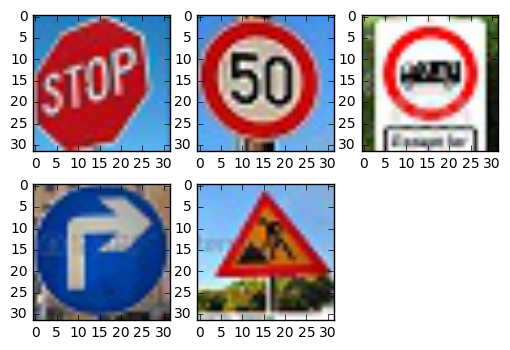

In [12]:
fig = plt.figure()
fig.add_subplot(2,3,1)
plt.imshow(imgs[0])
fig.add_subplot(2,3,2)
plt.imshow(imgs[1])
fig.add_subplot(2,3,3)
plt.imshow(imgs[2])
fig.add_subplot(2,3,4)
plt.imshow(imgs[3])
fig.add_subplot(2,3,5)
plt.imshow(imgs[4])

In [35]:
A=np.array(imgs)
A_t = cv2.cvtColor(A.reshape(A.shape[0], A.shape[1]*A.shape[2],A.shape[3]), cv2.COLOR_RGB2HSV)
 

A_t = A_t*(0.8)/255
 

 
    
A_t=A_t.reshape(A_t.shape[0], A_t.shape[1]*A_t.shape[2])
A_t=A_t.reshape(A_t.shape[0], 32,32,3)


In [37]:
preds = sess.run(predict, feed_dict={x: A_t})
print(preds)



[33  1 18 37  5]


### The sampled signs (upper row) and the predicted sign (lower row). 

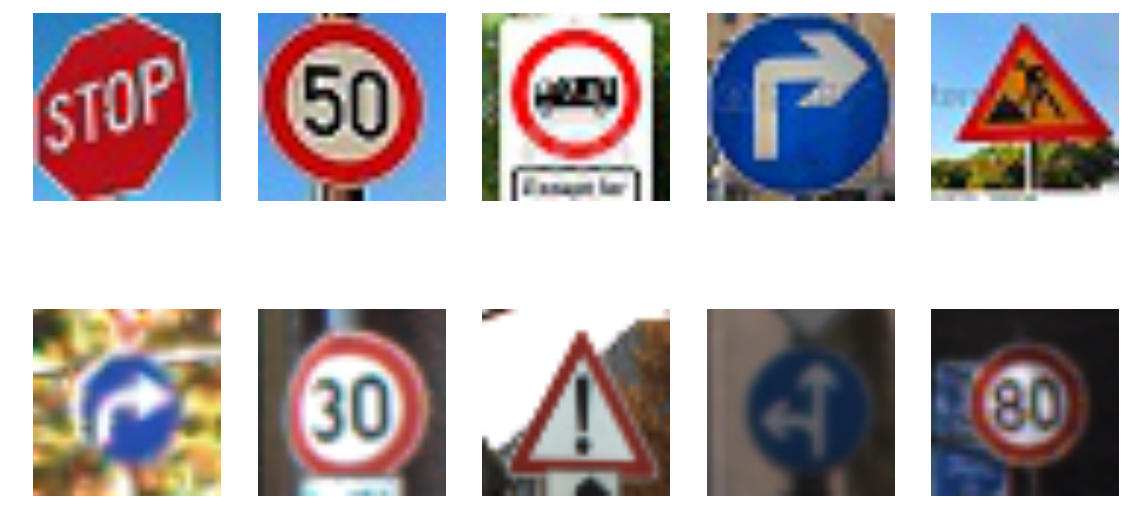

In [28]:
fig = plt.figure()
for i in [1,2,3,4,5]:
    fig.add_subplot(2,5,i)
    plt.imshow(A[i-1,:,:,:]) 
    plt.axis('off')
    fig.add_subplot(2,5,i+5)
    plt.imshow(label_type[preds[i-1]])
    plt.axis('off')

#### Figure : 
On the top raw the traffic signs obtaine from the internet. On the bottom row example of the predicted type of traffic sign from the training set. So for example, we can see that the stop sign was predicted correctly, but the "work on the road" sign was predicted as "maximum 80" . 

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:** Unfortunately the answer is no. For the test-set I obtained 70% where here the success is only ~40%.  I did try to choose figures that might be a challenge. For example, the working on road  sign has different colors. But my greatest surprise was that the model did not recognize the numbers correctly.  

In [29]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
top_k_preds = sess.run(tf.nn.top_k(prediction , k=5), feed_dict={x: A_t})
print(top_k_preds.values)
print(top_k_preds.indices)

[[  9.99909759e-01   4.87040597e-05   1.54477912e-05   1.38430059e-05
    9.71768895e-06]
 [  9.99979973e-01   1.10258397e-05   4.55613826e-06   2.28551266e-06
    1.36106883e-06]
 [  9.93701935e-01   6.29705284e-03   3.55569085e-07   3.42881691e-07
    3.05955751e-07]
 [  7.64819741e-01   1.93449020e-01   4.17306907e-02   2.72263577e-07
    1.89494870e-07]
 [  7.46735632e-01   2.52186894e-01   8.94639234e-04   1.61323333e-04
    6.02793943e-06]]
[[33 35 37 14 39]
 [ 1  7  4  2  0]
 [18  4 37 39 40]
 [37 33 39 40 12]
 [ 5 20 10 25 28]]


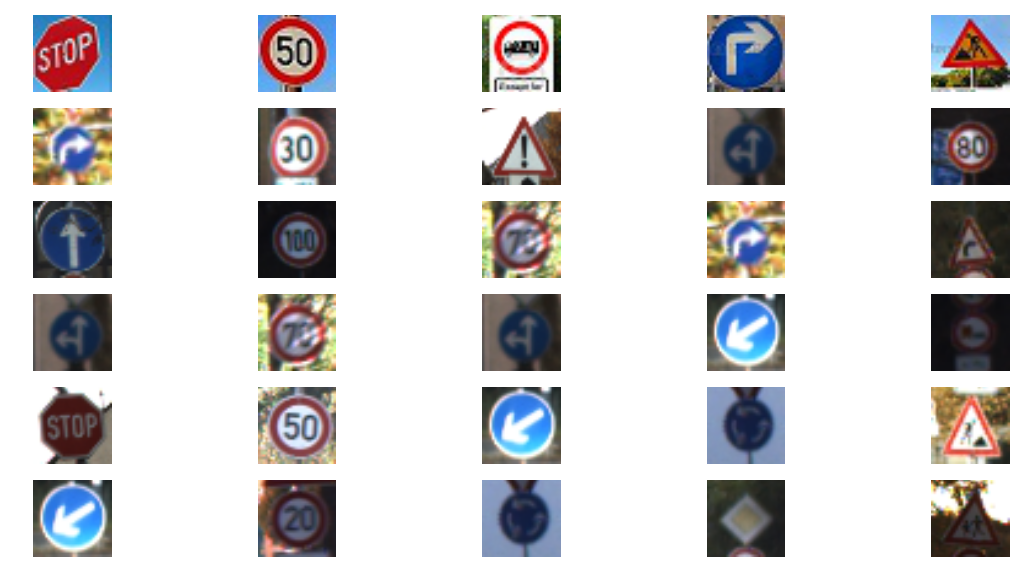

In [30]:
fig = plt.figure()

for i in [1,2,3,4,5]:
  
    fig.add_subplot(6,5,i)
    plt.imshow(A[i-1,:,:,:]) 
    plt.axis('off')
    for j in [0,1,2,3,4]:
      fig.add_subplot(6,5,i+(j+1)*5)
      plt.imshow(label_type[top_k_preds.indices[i-1][j]])
      plt.axis('off')
 
    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


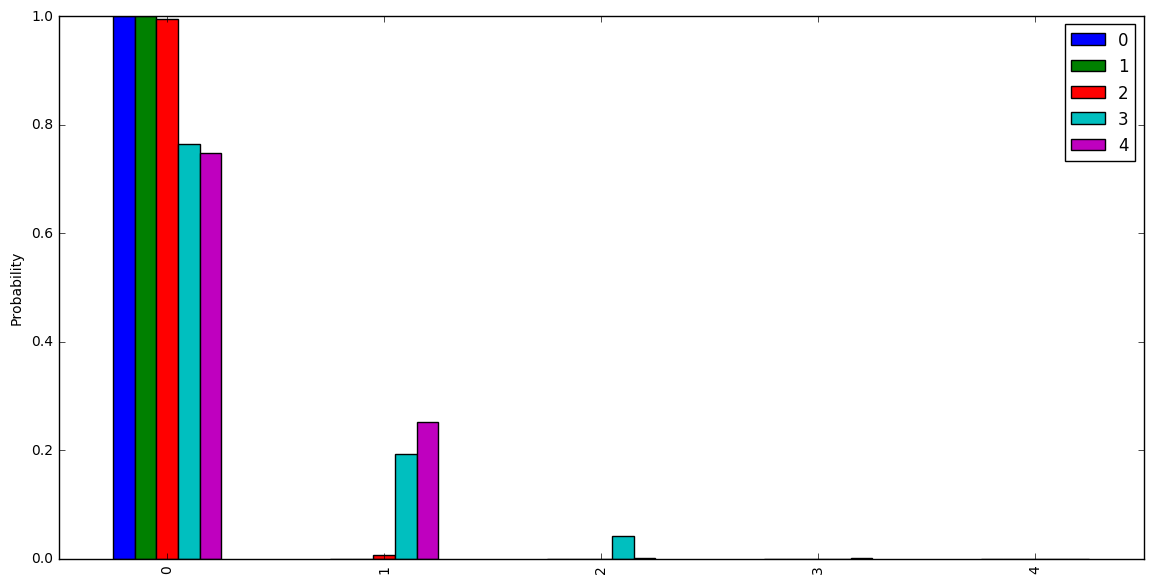

In [31]:
import pandas as pd
A=pd.DataFrame(top_k_preds.values.transpose())

A.plot(kind='bar').set_ylabel('Probability')

**Answer:** We find that for the "stop" sign, the "turn left" and the "trucks", the prediction probability is quite high, that is despite the fact that  the "truck" sign is a wrong prediction. For the other 2 predictions, we find that the probability is around 0.6 but the decrease in probability does not go fast as for the other 3. 

For the working on the road sign, we find the correct  prediction as number 3. That might also relate with the different colors of the signs.

Q: If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*
A: 
 * The prediction for the "stop" sign, the "turn left" are correct, 
 * The prediction for the "work on the road was not correct , but we find it as the third option. 
 * The prediction for the "truck" was wrong and we cannot find this prediction in the first 5 choises. 
 * The prediction for the "50" was wrong and we cannot find this prediction in the first 5 choises.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.